In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

In [3]:
# Define the days for d_500 to d_528
next_28_days_500 = [f'd_{i}' for i in range(500, 529)]

In [4]:
# Compute total sales for each item-store combination
sales_next_28_500 = sales_train_validation[['item_id', 'store_id', 'state_id'] + next_28_days_500].copy()
sales_next_28_500['total_sales'] = sales_next_28_500[next_28_days_500].sum(axis=1)

In [5]:
# Filter for non-zero sales
active_next_sales_500 = sales_next_28_500[sales_next_28_500['total_sales'] > 0]

In [6]:
# Extract unique identifiers
unique_items_500  = active_next_sales_500['item_id'].unique()
unique_stores_500 = active_next_sales_500['store_id'].unique()
unique_states_500 = active_next_sales_500['state_id'].unique()


In [7]:
# Grouping
state_sales_500 = active_next_sales_500.groupby('state_id')[next_28_days_500].sum().sum(axis=1).reset_index()
state_sales_500.columns = ['state_id', 'total_sales']

In [8]:
store_sales_500 = active_next_sales_500.groupby('store_id')[next_28_days_500].sum().sum(axis=1).reset_index()
store_sales_500.columns = ['store_id', 'total_sales']

In [9]:
item_sales_500 = active_next_sales_500.groupby('item_id')[next_28_days_500].sum().sum(axis=1).reset_index()
item_sales_500.columns = ['item_id', 'total_sales']
top_10_items_500 = item_sales_500.nlargest(10, 'total_sales')

In [10]:
# Total daily sales
total_sales_per_day_500 = active_next_sales_500[next_28_days_500].sum()

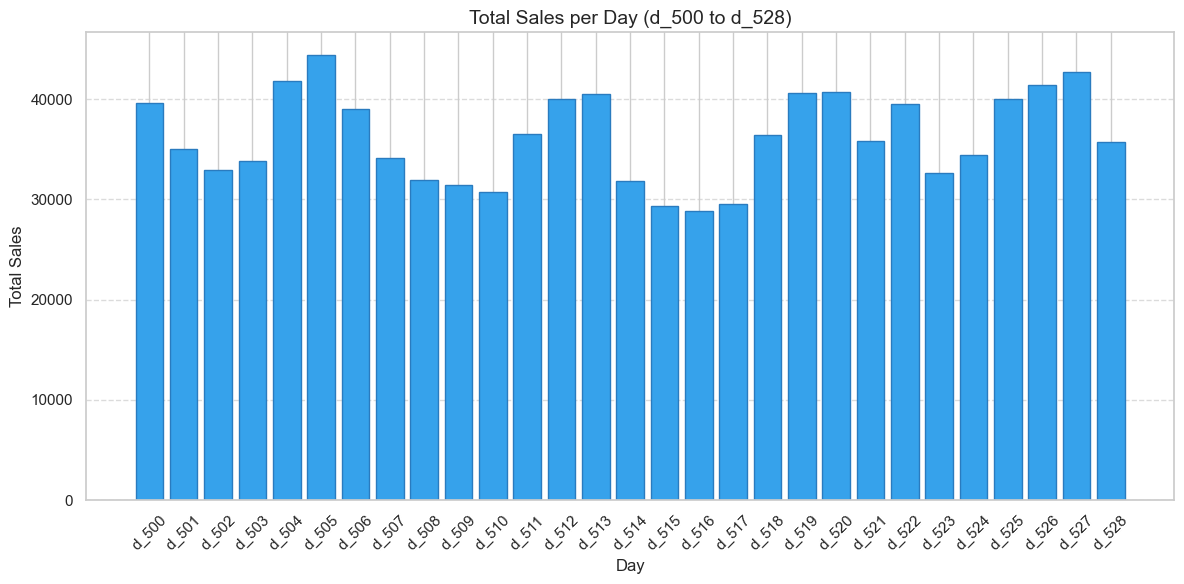

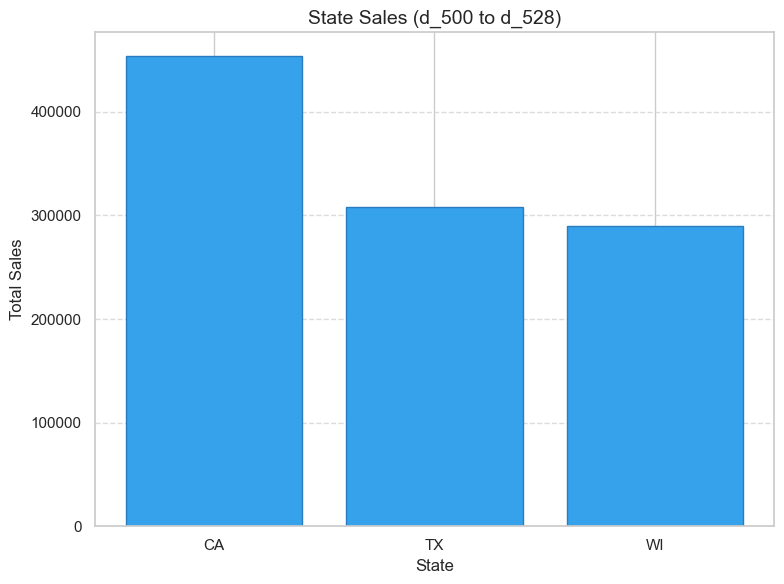

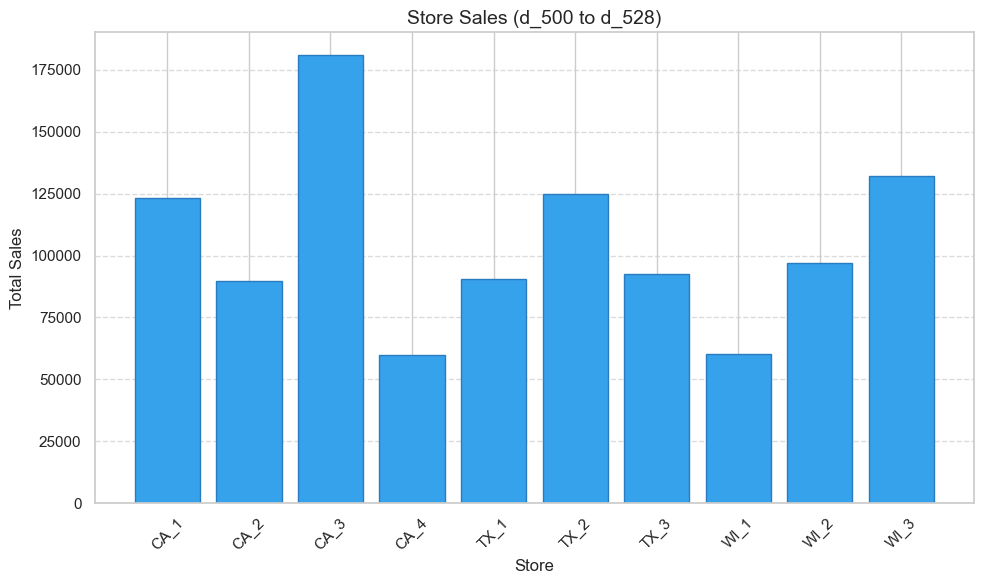

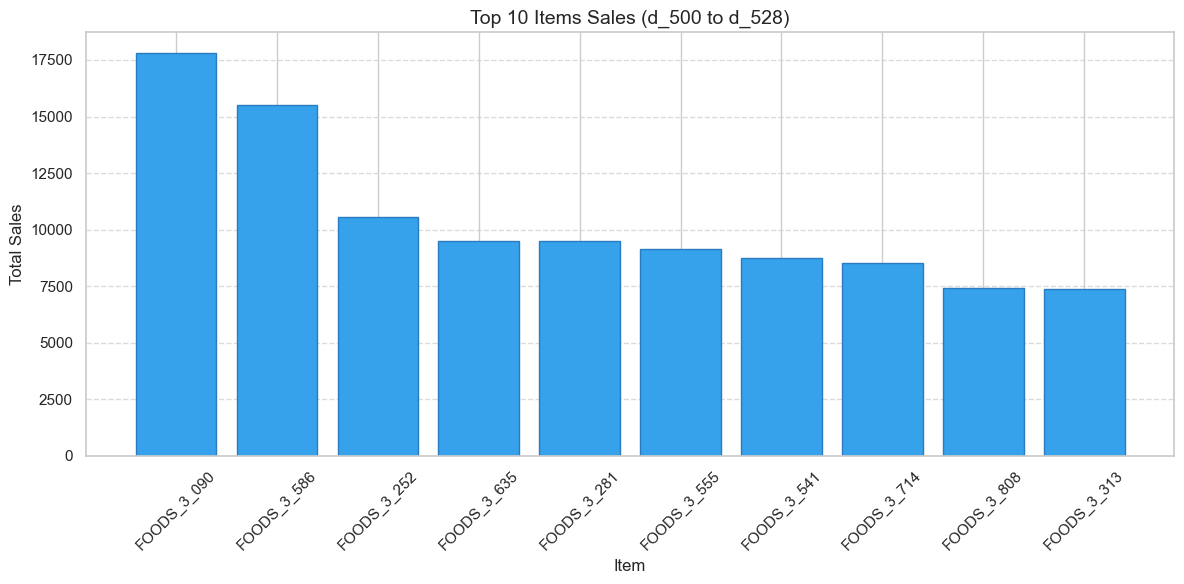

In [11]:
# Plotting
sns.set(style="whitegrid")
# Total Sales per Day
plt.figure(figsize=(12, 6))
plt.bar(next_28_days_500, total_sales_per_day_500, color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Total Sales per Day (d_500 to d_528)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('total_sales_per_day_500_528.png')
plt.show()

# State Sales
plt.figure(figsize=(8, 6))
plt.bar(state_sales_500['state_id'], state_sales_500['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('State Sales (d_500 to d_528)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('state_sales_500_528.png')
plt.show()

# Store Sales
plt.figure(figsize=(10, 6))
plt.bar(store_sales_500['store_id'], store_sales_500['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Store Sales (d_500 to d_528)', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('store_sales_500_528.png')
plt.show()

# Top 10 Items Sales
plt.figure(figsize=(12, 6))
plt.bar(top_10_items_500['item_id'], top_10_items_500['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Top 10 Items Sales (d_500 to d_528)', fontsize=14)
plt.xlabel('Item', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_items_sales_500_528.png')
plt.show()


In [12]:
# Use the same next_28_days_500 and active_next_sales_500 from earlier

# Item forecasts
item_forecasts_500 = active_next_sales_500.groupby('item_id')[next_28_days_500].mean().mean(axis=1).reset_index()
item_forecasts_500.columns = ['item_id', 'forecast']

# Store forecasts
store_forecasts_500 = active_next_sales_500.groupby('store_id')[next_28_days_500].mean().mean(axis=1).reset_index()
store_forecasts_500.columns = ['store_id', 'forecast']

# State forecasts
state_forecasts_500 = active_next_sales_500.groupby('state_id')[next_28_days_500].mean().mean(axis=1).reset_index()
state_forecasts_500.columns = ['state_id', 'forecast']

# Total forecast
total_forecast_500 = active_next_sales_500[next_28_days_500].mean().mean()
total_forecast_500 = pd.DataFrame({'level': ['total'], 'forecast': [total_forecast_500]})

# Build summing matrix
items_500 = active_next_sales_500['item_id'].unique()
stores_500 = active_next_sales_500['store_id'].unique()
states_500 = active_next_sales_500['state_id'].unique()

item_to_store_500 = active_next_sales_500[['item_id', 'store_id']].drop_duplicates().set_index('item_id')['store_id']
item_to_state_500 = active_next_sales_500[['item_id', 'state_id']].drop_duplicates().set_index('item_id')['state_id']
store_to_state_500 = active_next_sales_500[['store_id', 'state_id']].drop_duplicates().set_index('store_id')['state_id']

n_items = len(items_500)
n_stores = len(stores_500)
n_states = len(states_500)
n_total = 1
n_bottom = n_items
n_total_nodes = n_total + n_states + n_stores + n_items

S_500 = np.zeros((n_total_nodes, n_bottom))

item_idx_500 = {item: i for i, item in enumerate(items_500)}
store_idx_500 = {store: i + n_total + n_states for i, store in enumerate(stores_500)}
state_idx_500 = {state: i + n_total for i, state in enumerate(states_500)}
total_idx_500 = 0

S_500[total_idx_500, :] = 1

for item in items_500:
    state = item_to_state_500.loc[item]
    store = item_to_store_500.loc[item]
    if isinstance(state, pd.Series): state = state.iloc[0]
    if isinstance(store, pd.Series): store = store.iloc[0]
    S_500[state_idx_500[state], item_idx_500[item]] = 1
    S_500[store_idx_500[store], item_idx_500[item]] = 1

for i in range(n_items):
    S_500[n_total + n_states + n_stores + i, i] = 1

# Base forecast vector
base_forecasts_500 = np.zeros(n_total_nodes)
base_forecasts_500[total_idx_500] = total_forecast_500['forecast'].values[0]

for state in states_500:
    base_forecasts_500[state_idx_500[state]] = state_forecasts_500[state_forecasts_500['state_id'] == state]['forecast'].values[0]
for store in stores_500:
    base_forecasts_500[store_idx_500[store]] = store_forecasts_500[store_forecasts_500['store_id'] == store]['forecast'].values[0]
for item in items_500:
    base_forecasts_500[n_total + n_states + n_stores + item_idx_500[item]] = item_forecasts_500[item_forecasts_500['item_id'] == item]['forecast'].values[0]

# BU and MinT
bu_forecasts_500 = np.dot(S_500, base_forecasts_500[n_total + n_states + n_stores:])
G_500 = np.linalg.pinv(S_500.T @ S_500) @ S_500.T
reconciled_forecasts_500 = np.dot(S_500, G_500 @ base_forecasts_500)

# Reconciled DataFrame
reconciled_df_500_528 = pd.DataFrame({
    'level': ['total'] + list(states_500) + list(stores_500) + list(items_500),
    'base_forecast': base_forecasts_500,
    'bu_forecast': bu_forecasts_500,
    'mint_forecast': reconciled_forecasts_500
})


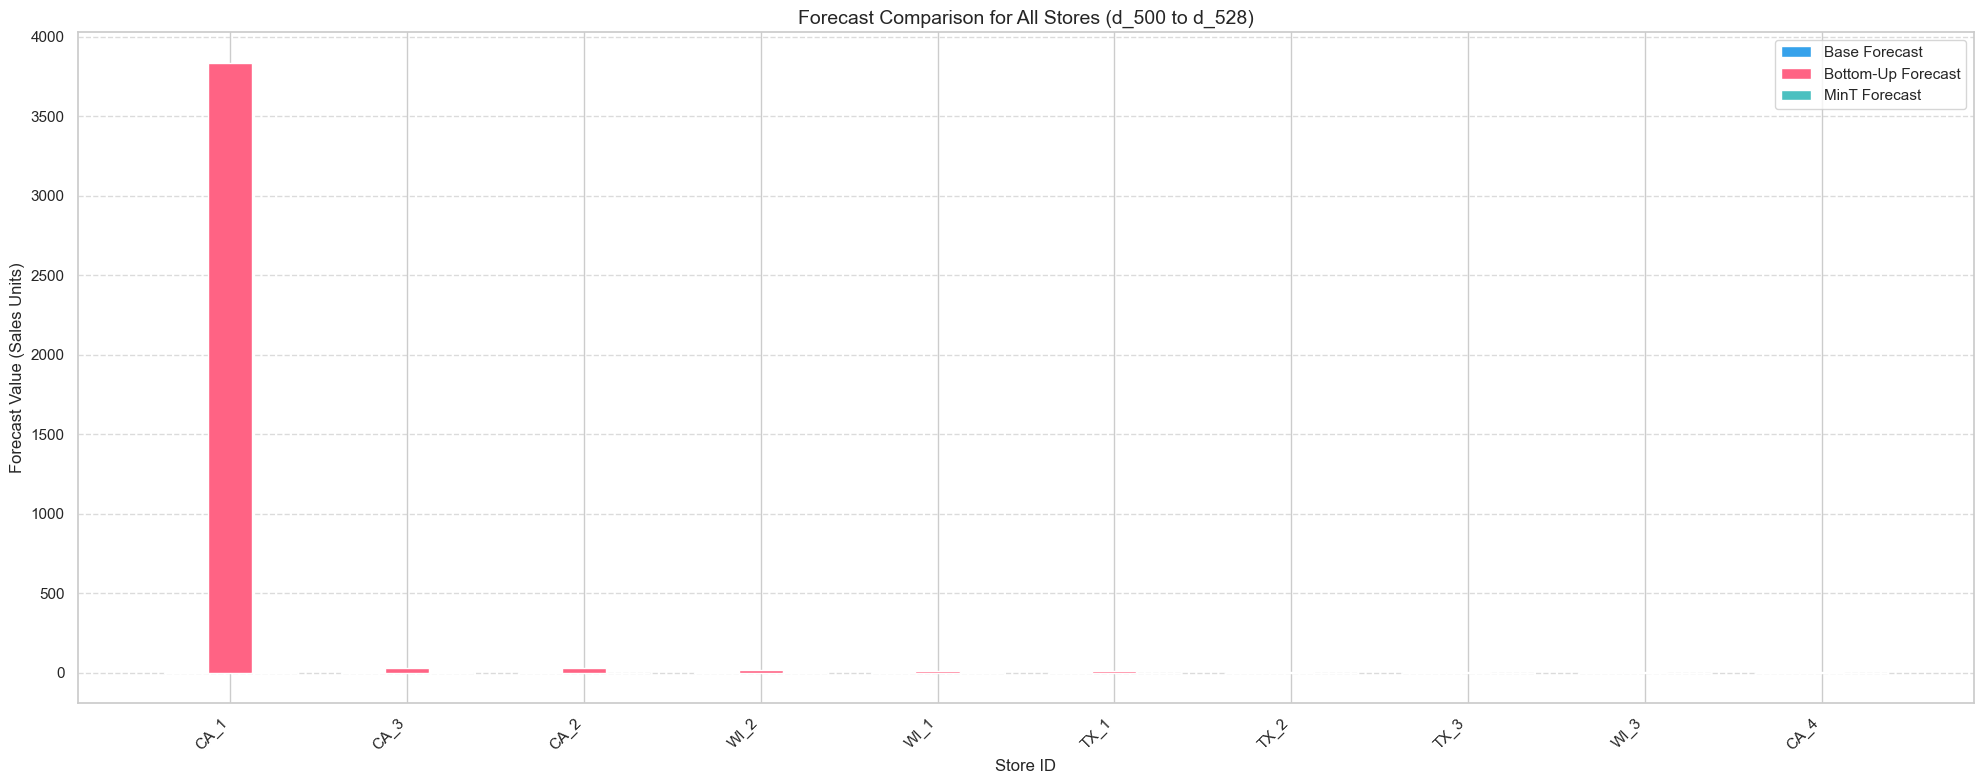

In [13]:
# Forecast Comparison for All Stores (d_500 to d_528)
# Use reconciled_df_500_528 assumed to be already computed

store_df_500_528 = reconciled_df_500_528[reconciled_df_500_528['level'].isin(store_sales_500['store_id'])].copy()
store_df_500_528['avg_forecast'] = store_df_500_528[['base_forecast', 'bu_forecast', 'mint_forecast']].mean(axis=1)
store_df_500_528 = store_df_500_528.sort_values(by='avg_forecast', ascending=False)

# Plot forecast comparison
fig, ax = plt.subplots(figsize=(20, 8))
bar_width = 0.25
index = np.arange(len(store_df_500_528))

ax.bar(index, store_df_500_528['base_forecast'], bar_width, label='Base Forecast', color='#36A2EB')
ax.bar(index + bar_width, store_df_500_528['bu_forecast'], bar_width, label='Bottom-Up Forecast', color='#FF6384')
ax.bar(index + 2 * bar_width, store_df_500_528['mint_forecast'], bar_width, label='MinT Forecast', color='#4BC0C0')

ax.set_xlabel('Store ID', fontsize=12)
ax.set_ylabel('Forecast Value (Sales Units)', fontsize=12)
ax.set_title('Forecast Comparison for All Stores (d_500 to d_528)', fontsize=14)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(store_df_500_528['level'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('forecast_comparison_all_stores_500_528.png')
plt.show()

100%|██████████| 17689/17689 [2:02:08<00:00,  2.41it/s] 


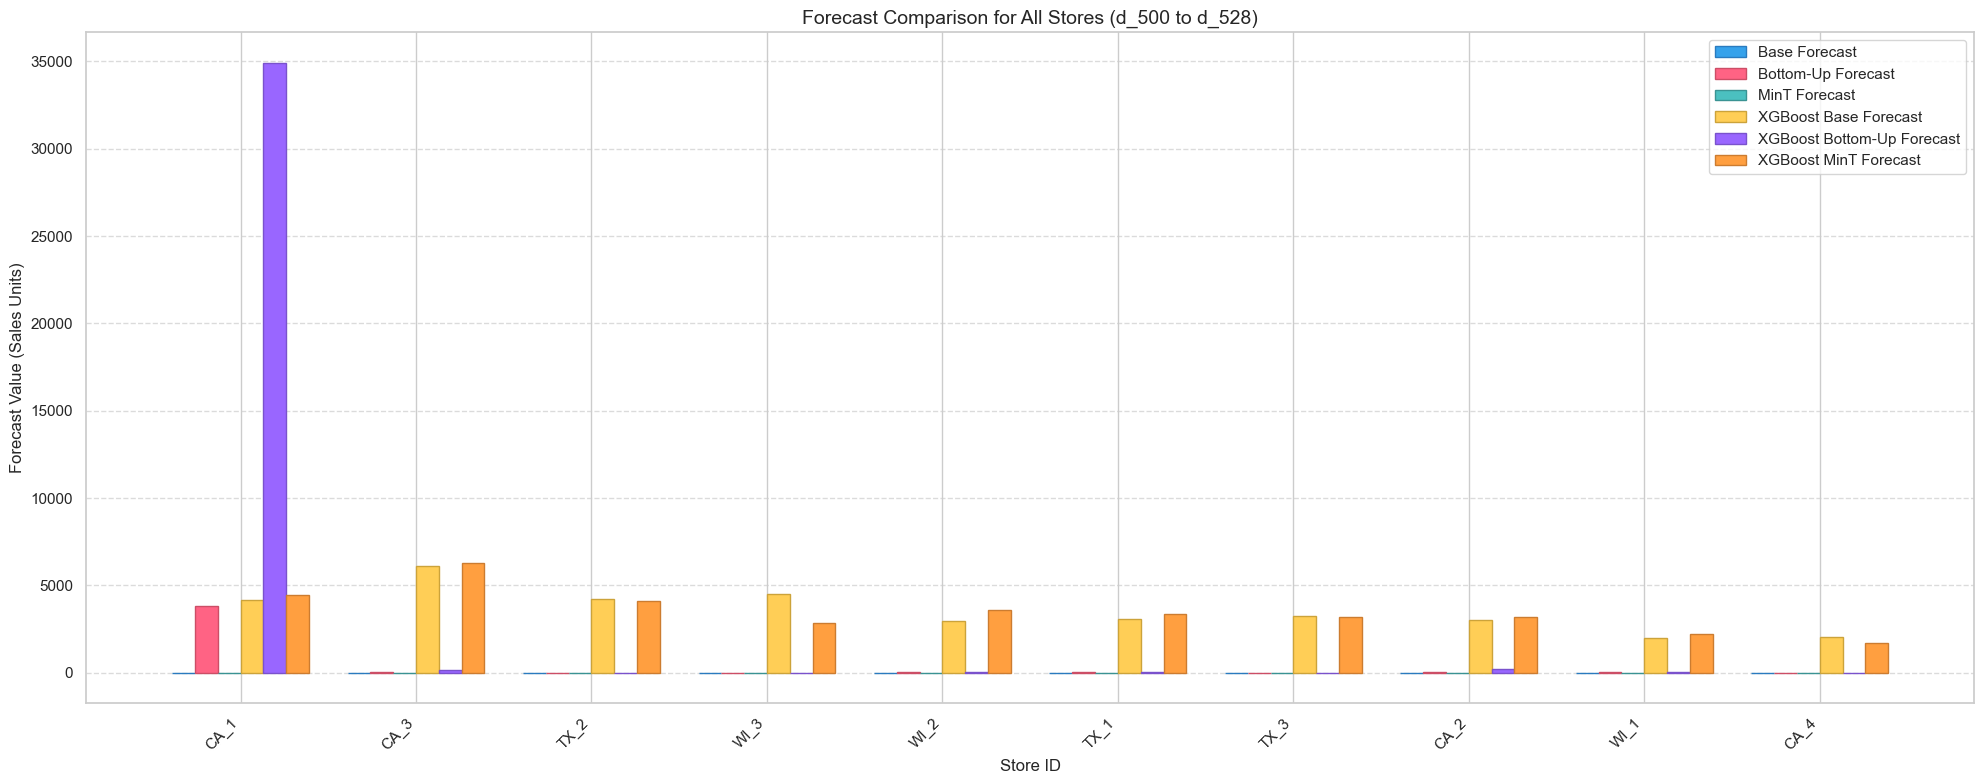

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assuming sales_train_validation is already loaded
# Define the days for d_500 to d_528
next_28_days_500 = [f'd_{i}' for i in range(500, 529)]

# Compute total sales for each item-store combination
sales_next_28_500 = sales_train_validation[['item_id', 'store_id', 'state_id'] + next_28_days_500].copy()
sales_next_28_500['total_sales'] = sales_next_28_500[next_28_days_500].sum(axis=1)

# Filter for non-zero sales
active_next_sales_500 = sales_next_28_500[sales_next_28_500['total_sales'] > 0]

# Prepare data for XGBoost
def prepare_xgboost_data(df, item_id, store_id, lag_days=7):
    # Filter for specific item-store combination
    item_store_df = df[(df['item_id'] == item_id) & (df['store_id'] == store_id)]
    
    # Melt the data to long format
    days = [col for col in df.columns if col.startswith('d_')]
    melted = pd.melt(item_store_df, id_vars=['item_id', 'store_id', 'state_id'], 
                     value_vars=days, var_name='day', value_name='sales')
    melted['day_num'] = melted['day'].str.extract(r'(\d+)').astype(int)
    
    # Create lagged features
    for lag in range(1, lag_days + 1):
        melted[f'lag_{lag}'] = melted.groupby(['item_id', 'store_id'])['sales'].shift(lag)
    
    # Drop rows with NaN (due to lags)
    melted = melted.dropna()
    
    # Add temporal features
    melted['day_of_week'] = melted['day_num'] % 7
    
    return melted

# Train XGBoost model for each item-store combination
xgb_forecasts = []
unique_item_store = active_next_sales_500[['item_id', 'store_id']].drop_duplicates()

for _, row in tqdm(unique_item_store.iterrows(), total=len(unique_item_store)):
    item_id = row['item_id']
    store_id = row['store_id']
    
    # Prepare data
    data = prepare_xgboost_data(sales_train_validation, item_id, store_id)
    
    # Split into train (up to d_499) and test (d_500 to d_528)
    train_data = data[data['day_num'] < 500]
    test_data = data[data['day_num'].isin(range(500, 529))]
    
    if len(train_data) < 10:  # Skip if insufficient data
        continue
    
    # Features and target
    features = [f'lag_{i}' for i in range(1, 8)] + ['day_of_week']
    X_train = train_data[features]
    y_train = train_data['sales']
    X_test = test_data[features]
    
    # Train XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict for d_500 to d_528
    predictions = model.predict(X_test)
    
    # Store forecasts
    forecast_df = pd.DataFrame({
        'item_id': item_id,
        'store_id': store_id,
        'day': test_data['day'],
        'forecast': predictions
    })
    xgb_forecasts.append(forecast_df)

# Combine forecasts
xgb_forecasts_df = pd.concat(xgb_forecasts)

# Pivot forecasts to wide format
xgb_forecasts_pivot = xgb_forecasts_df.pivot_table(index=['item_id', 'store_id'], 
                                                  columns='day', values='forecast').reset_index()
xgb_forecasts_pivot.columns = ['item_id', 'store_id'] + list(xgb_forecasts_pivot.columns[2:])

# Compute mean forecast for each item-store
item_store_forecasts_xgb = xgb_forecasts_pivot.groupby(['item_id', 'store_id'])[next_28_days_500].mean().mean(axis=1).reset_index()
item_store_forecasts_xgb.columns = ['item_id', 'store_id', 'xgb_forecast']


# ... (previous code remains unchanged until the aggregation section)

# Aggregate forecasts
item_forecasts_xgb = item_store_forecasts_xgb.groupby('item_id')['xgb_forecast'].sum().reset_index()
item_forecasts_xgb.columns = ['item_id', 'xgb_forecast']

store_forecasts_xgb = item_store_forecasts_xgb.groupby('store_id')['xgb_forecast'].sum().reset_index()
store_forecasts_xgb.columns = ['store_id', 'xgb_forecast']

# Corrected line: Merge and aggregate state forecasts
state_forecasts_xgb = item_store_forecasts_xgb.merge(active_next_sales_500[['store_id', 'state_id']].drop_duplicates(), 
                                                    on='store_id')
state_forecasts_xgb = state_forecasts_xgb.groupby('state_id')['xgb_forecast'].sum().reset_index()
state_forecasts_xgb.columns = ['state_id', 'xgb_forecast']

total_forecast_xgb = item_store_forecasts_xgb['xgb_forecast'].sum()
total_forecast_xgb = pd.DataFrame({'level': ['total'], 'xgb_forecast': [total_forecast_xgb]})

# Update base forecasts with XGBoost forecasts
base_forecasts_xgb = np.zeros(n_total_nodes)
base_forecasts_xgb[total_idx_500] = total_forecast_xgb['xgb_forecast'].values[0]

for state in states_500:
    base_forecasts_xgb[state_idx_500[state]] = state_forecasts_xgb[state_forecasts_xgb['state_id'] == state]['xgb_forecast'].values[0]
for store in stores_500:
    base_forecasts_xgb[store_idx_500[store]] = store_forecasts_xgb[store_forecasts_xgb['store_id'] == store]['xgb_forecast'].values[0]
for item in items_500:
    base_forecasts_xgb[n_total + n_states + n_stores + item_idx_500[item]] = item_forecasts_xgb[item_forecasts_xgb['item_id'] == item]['xgb_forecast'].values[0]

# Reconcile forecasts
bu_forecasts_xgb = np.dot(S_500, base_forecasts_xgb[n_total + n_states + n_stores:])
reconciled_forecasts_xgb = np.dot(S_500, G_500 @ base_forecasts_xgb)

# Update reconciled DataFrame
reconciled_df_500_528['xgb_base_forecast'] = base_forecasts_xgb
reconciled_df_500_528['xgb_bu_forecast'] = bu_forecasts_xgb
reconciled_df_500_528['xgb_mint_forecast'] = reconciled_forecasts_xgb

# Plot Forecast Comparison for All Stores (d_500 to d_528) using matplotlib
store_df_500_528 = reconciled_df_500_528[reconciled_df_500_528['level'].isin(store_sales_500['store_id'])].copy()
store_df_500_528['avg_forecast'] = store_df_500_528[['base_forecast', 'bu_forecast', 'mint_forecast', 
                                                    'xgb_base_forecast', 'xgb_bu_forecast', 'xgb_mint_forecast']].mean(axis=1)
store_df_500_528 = store_df_500_528.sort_values(by='avg_forecast', ascending=False)

# Set seaborn style
sns.set(style="whitegrid")

# Create bar plot
fig, ax = plt.subplots(figsize=(20, 8))
bar_width = 0.13  # Adjusted for six bars
index = np.arange(len(store_df_500_528))

# Plot each forecast type
ax.bar(index, store_df_500_528['base_forecast'], bar_width, label='Base Forecast', color='#36A2EB', edgecolor='#2A7BBF')
ax.bar(index + bar_width, store_df_500_528['bu_forecast'], bar_width, label='Bottom-Up Forecast', color='#FF6384', edgecolor='#CC4E66')
ax.bar(index + 2 * bar_width, store_df_500_528['mint_forecast'], bar_width, label='MinT Forecast', color='#4BC0C0', edgecolor='#3A9393')
ax.bar(index + 3 * bar_width, store_df_500_528['xgb_base_forecast'], bar_width, label='XGBoost Base Forecast', color='#FFCE56', edgecolor='#CCA33A')
ax.bar(index + 4 * bar_width, store_df_500_528['xgb_bu_forecast'], bar_width, label='XGBoost Bottom-Up Forecast', color='#9966FF', edgecolor='#7A52CC')
ax.bar(index + 5 * bar_width, store_df_500_528['xgb_mint_forecast'], bar_width, label='XGBoost MinT Forecast', color='#FF9F40', edgecolor='#CC7C30')

# Customize plot
ax.set_xlabel('Store ID', fontsize=12)
ax.set_ylabel('Forecast Value (Sales Units)', fontsize=12)
ax.set_title('Forecast Comparison for All Stores (d_500 to d_528)', fontsize=14)
ax.set_xticks(index + 2.5 * bar_width)
ax.set_xticklabels(store_df_500_528['level'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('forecast_comparison_all_stores_500_528.png')
plt.show()

In [15]:
# Actual mean sales per store from d_500 to d_528
actual_forecast_store = actual_sales_store_500.copy()
actual_forecast_store['actual_mean'] = actual_forecast_store[next_28_days_500].mean(axis=1)
actual_forecast_store = actual_forecast_store[['store_id', 'actual_mean']]

# Extract only store-level forecasts from reconciled_df
forecast_store_df = reconciled_df_500_528[reconciled_df_500_528['level'].isin(actual_forecast_store['store_id'])].copy()
forecast_store_df = forecast_store_df.rename(columns={'level': 'store_id'})

# Merge with actual
forecast_vs_actual = pd.merge(forecast_store_df, actual_forecast_store, on='store_id', how='inner')

from sklearn.metrics import mean_squared_error
from math import sqrt

# Dictionary to store RMSEs
rmse_scores = {}

# List of forecast types
forecast_types = ['base_forecast', 'bu_forecast', 'mint_forecast',
                  'xgb_base_forecast', 'xgb_bu_forecast', 'xgb_mint_forecast']

# Compute RMSE for each
for forecast in forecast_types:
    rmse = sqrt(mean_squared_error(forecast_vs_actual['actual_mean'], forecast_vs_actual[forecast]))
    rmse_scores[forecast] = rmse

# Display RMSEs
for k, v in rmse_scores.items():
    print(f"{k} RMSE: {v:.2f}")


NameError: name 'actual_sales_store_500' is not defined